In [1]:
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt

import energyflow as ef

In [2]:
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.family'] = 'serif'

In [3]:
from graph_data import GraphDataset
gdata = GraphDataset(root='/home/jovyan/.energyflow/datasets/')

In [4]:
print(gdata[5].u)
print(gdata[5].y)
print(gdata[5].edge_index)
print(sum(gdata[5].x[0:18,0]))
len(gdata)

tensor([[5.0082, 4.9424]])
tensor([[2.2362]])
tensor([[ 0,  0,  0,  ..., 17, 17, 17],
        [18, 19, 20,  ..., 76, 77, 78]])
tensor(1.)


10000

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import EdgeConv, global_mean_pool
from torch_scatter import scatter_mean

class EdgeNet(nn.Module):
    def __init__(self, input_dim=3, big_dim=32, bigger_dim=128, global_dim=2, output_dim=1, aggr='mean'):
        super(EdgeNet, self).__init__()
        convnn = nn.Sequential(nn.Linear(2*(input_dim), big_dim),
                               nn.ReLU(),
                               nn.Linear(big_dim, big_dim),
                               nn.ReLU(),
                               nn.Linear(big_dim, big_dim),
                               nn.ReLU(),
        )
                
        self.batchnorm = nn.BatchNorm1d(input_dim)
        
        self.batchnormglobal = nn.BatchNorm1d(global_dim)        
        
        self.outnn = nn.Sequential(nn.Linear(big_dim+global_dim, bigger_dim),
                                   nn.ReLU(),
                                   nn.Linear(bigger_dim, bigger_dim),
                                   nn.ReLU(),
                                   nn.Linear(bigger_dim, output_dim)
        )
        
        self.conv = EdgeConv(nn=convnn,aggr=aggr)

    def forward(self, data):
        data.x = self.batchnorm(data.x)
        data.x = self.conv(data.x,data.edge_index)
        u1 = self.batchnormglobal(data.u)
        u2 = scatter_mean(data.x, data.batch, dim=0)
        data.u = torch.cat([u1, u2],dim=-1)
        return self.outnn(data.u)

In [6]:
input_dim = 3
big_dim = 32
bigger_dim = 128
global_dim = 2
output_dim = 1
fulllen = len(gdata)
tv_frac = 0.10
tv_num = math.ceil(fulllen*tv_frac)
batch_size = 128
lr = 0.001
device = 'cuda:0'
model_fname = 'EdgeNet'

model = EdgeNet(input_dim=input_dim, big_dim=big_dim, bigger_dim=bigger_dim, 
                global_dim=global_dim, output_dim=output_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [7]:
from torch_geometric.data import Data, DataLoader
from torch.utils.data import random_split
train_dataset, valid_dataset, test_dataset = random_split(gdata, [fulllen-2*tv_num,tv_num,tv_num])

train_loader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)

train_samples = len(train_dataset)
valid_samples = len(valid_dataset)
test_samples = len(test_dataset)

print(train_samples)
print(valid_samples)
print(test_samples)


8000
1000
1000


In [8]:
import tqdm
@torch.no_grad()
def test(model,loader,total,batch_size):
    model.eval()
    
    mse = nn.MSELoss(reduction='mean')

    sum_loss = 0.
    t = tqdm.tqdm(enumerate(loader),total=total/batch_size)
    for i,data in t:
        data = data.to(device)
        batch_output = model(data)
        batch_loss_item = mse(batch_output, data.y).item()
        sum_loss += batch_loss_item
        t.set_description("loss = %.5f" % (batch_loss_item))
        t.refresh() # to show immediately the update

    return sum_loss/(i+1)

def train(model, optimizer, loader, total, batch_size):
    model.train()
    
    mse = nn.MSELoss(reduction='mean')

    sum_loss = 0.
    t = tqdm.tqdm(enumerate(loader),total=total/batch_size)
    for i,data in t:
        data = data.to(device)
        optimizer.zero_grad()
        batch_output = model(data)
        batch_loss = mse(batch_output, data.y)
        batch_loss.backward()
        batch_loss_item = batch_loss.item()
        t.set_description("loss = %.5f" % batch_loss_item)
        t.refresh() # to show immediately the update
        sum_loss += batch_loss_item
        optimizer.step()
    
    return sum_loss/(i+1)

In [9]:
import os.path as osp

n_epochs = 100
patience = 10
stale_epochs = 0
best_valid_loss = 99999
for epoch in range(0, n_epochs):
    loss = train(model, optimizer, train_loader, train_samples, batch_size)
    valid_loss = test(model, valid_loader, valid_samples, batch_size)
    print('Epoch: {:02d}, Training Loss:   {:.4f}'.format(epoch, loss))
    print('               Validation Loss: {:.4f}'.format(valid_loss))

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        modpath = osp.join('/home/jovyan/work/EnergyFlow/demos/',model_fname+'.best.pth')
        print('New best model saved to:',modpath)
        torch.save(model.state_dict(),modpath)
        stale_epochs = 0
    else:
        print('Stale epoch')
        stale_epochs += 1
    if stale_epochs >= patience:
        print('Early stopping after %i stale epochs'%patience)
        break

loss = 0.27596: : 63it [00:45,  1.37it/s]                        
loss = 0.28348:  90%|████████▉ | 7/7.8125 [00:05<00:00,  1.40it/s]/opt/conda/lib/python3.7/site-packages/tqdm/std.py:521: TqdmWarning: clamping frac to range [0, 1]
  colour=colour)
loss = 0.28348: 102%|██████████| 8/7.8125 [00:05<00:00,  1.44it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 00, Training Loss:   0.3957
               Validation Loss: 0.2620
New best model saved to: /home/jovyan/work/EnergyFlow/demos/EdgeNet.best.pth


loss = 0.23042: : 63it [00:43,  1.44it/s]                        
loss = 0.22948: 102%|██████████| 8/7.8125 [00:05<00:00,  1.54it/s]
  0%|          | 0/62.5 [00:00<?, ?it/s]

Epoch: 01, Training Loss:   0.2595
               Validation Loss: 0.2167
New best model saved to: /home/jovyan/work/EnergyFlow/demos/EdgeNet.best.pth


loss = 0.13068: : 63it [00:43,  1.44it/s]                        
loss = 0.14087: 102%|██████████| 8/7.8125 [00:05<00:00,  1.53it/s]

Epoch: 02, Training Loss:   0.1672
               Validation Loss: 0.1423
New best model saved to: /home/jovyan/work/EnergyFlow/demos/EdgeNet.best.pth


In [10]:
model.load_state_dict(torch.load(modpath))
ys = []
preds = []
diffs = []

from graph_data import ONE_HUNDRED_GEV

t = tqdm.tqdm(enumerate(test_loader),total=test_samples/batch_size)
for i, data in t:
    data.to(device)
    ys.append(data.y.cpu().numpy().squeeze()*ONE_HUNDRED_GEV)
    preds.append(model(data).cpu().detach().numpy().squeeze()*ONE_HUNDRED_GEV)
    
ys = np.concatenate(ys)   
preds = np.concatenate(preds)   
diffs = (preds-ys)

102%|██████████| 8/7.8125 [00:05<00:00,  1.45it/s]


Text(0, 0.5, 'Pred. EMD [GeV]')

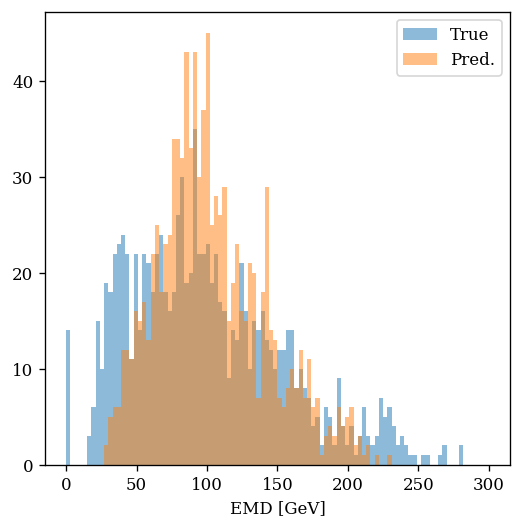

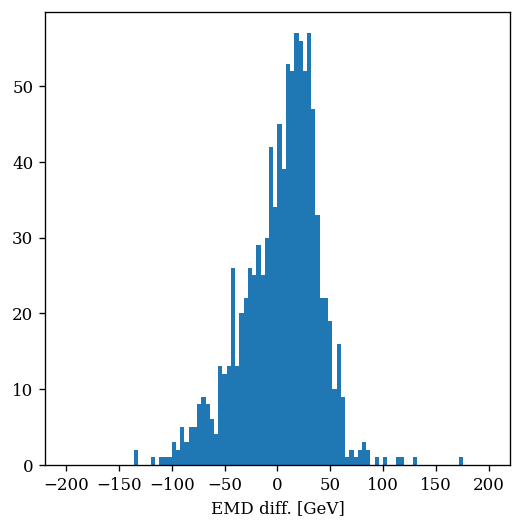

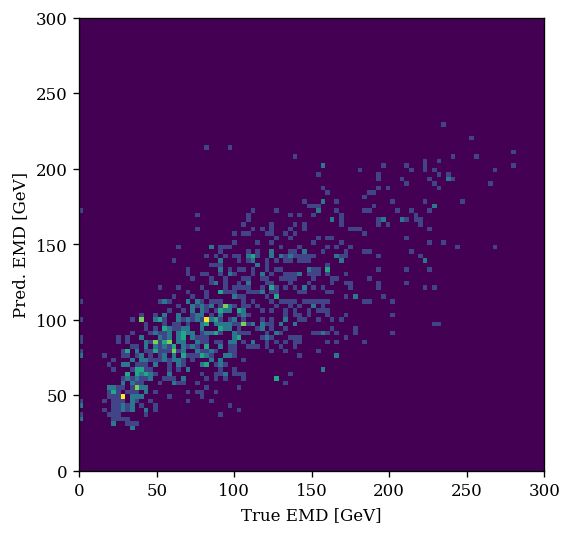

In [11]:
fig, ax = plt.subplots(figsize =(5, 5)) 
plt.hist(ys, bins=np.linspace(0, 300, 101),label='True', alpha=0.5)
plt.hist(preds, bins=np.linspace(0, 300, 101),label = 'Pred.', alpha=0.5)
plt.legend()
ax.set_xlabel('EMD [GeV]') 

fig, ax = plt.subplots(figsize =(5, 5)) 
plt.hist(diffs, bins=np.linspace(-200, 200, 101))
ax.set_xlabel('EMD diff. [GeV]')  

fig, ax = plt.subplots(figsize =(5, 5)) 
x_bins = np.linspace(0, 300, 101)
y_bins = np.linspace(0, 300, 101)
plt.hist2d(ys, preds, bins=[x_bins,y_bins])
ax.set_xlabel('True EMD [GeV]')  
ax.set_ylabel('Pred. EMD [GeV]')